<h1>Named entity recognition with Bert</h1>

In [56]:
%%capture
!pip install transformers==2.6.0
!pip install seqeval==1.0.0

# Load the data


In [57]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv("/content/drive/MyDrive/datasets/ner_dataset/ner_dataset.csv", encoding="latin1").fillna(method="ffill")
data.tail(10)


,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [58]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [59]:
getter = SentenceGetter(data)

In [60]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [61]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [62]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [63]:
tag2idx

{'B-art': 10,
 'B-eve': 13,
 'B-geo': 2,
 'B-gpe': 3,
 'B-nat': 12,
 'B-org': 0,
 'B-per': 16,
 'B-tim': 14,
 'I-art': 8,
 'I-eve': 15,
 'I-geo': 7,
 'I-gpe': 6,
 'I-nat': 9,
 'I-org': 4,
 'I-per': 5,
 'I-tim': 11,
 'O': 1,
 'PAD': 17}

# Apply Bert
## **Prepare the sentences and labels**

In [64]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__


'1.10.0+cu111'

In [65]:
MAX_LEN = 75
bs = 32


In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [67]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [68]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [69]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]


In [70]:
tokenized_texts_and_labels[:1]

[(['Thousands',
   'of',
   'demons',
   '##tra',
   '##tors',
   'have',
   'marched',
   'through',
   'London',
   'to',
   'protest',
   'the',
   'war',
   'in',
   'Iraq',
   'and',
   'demand',
   'the',
   'withdrawal',
   'of',
   'British',
   'troops',
   'from',
   'that',
   'country',
   '.'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-geo',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-geo',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-gpe',
   'O',
   'O',
   'O',
   'O',
   'O'])]

In [71]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [72]:
tokenized_texts[:1]

[['Thousands',
  'of',
  'demons',
  '##tra',
  '##tors',
  'have',
  'marched',
  'through',
  'London',
  'to',
  'protest',
  'the',
  'war',
  'in',
  'Iraq',
  'and',
  'demand',
  'the',
  'withdrawal',
  'of',
  'British',
  'troops',
  'from',
  'that',
  'country',
  '.']]

In [73]:
labels[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O']

In [74]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [75]:
input_ids[:1]

array([[26159,  1104,  8568,  4487,  5067,  1138,  9639,  1194,  1498,
         1106,  5641,  1103,  1594,  1107,  5008,  1105,  4555,  1103,
        10602,  1104,  1418,  2830,  1121,  1115,  1583,   119,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]])

In [76]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [77]:
tags[0]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  2,  1,  1,
        1,  1,  1,  3,  1,  1,  1,  1,  1, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17])

In [78]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [79]:
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [80]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=123, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=123, test_size=0.2)


In [81]:
print(input_ids.shape)  # input data
print(tr_inputs.shape)  # train data
print(val_inputs.shape) # valid data

(47959, 75)
(38367, 75)
(9592, 75)


In [82]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [83]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)




---



# Setup the Bert model for finetuning

In [84]:
import transformers
from transformers import BertForTokenClassification, AdamW
transformers.__version__


'2.6.0'

In [85]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


In [86]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [87]:
model.cuda();

In [88]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [89]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [90]:
from transformers import get_linear_schedule_with_warmup

epochs = 5
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


# Fit BERT for named entity recognition

In [91]:
from seqeval.metrics import f1_score, accuracy_score
from seqeval.metrics import classification_report

In [92]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Average train loss: 0.19542662957504553
Validation loss: 0.13606723866115014
Validation Accuracy: 0.9572266198809115


Epoch:  20%|██        | 1/5 [08:46<35:05, 526.27s/it]

Validation F1-Score: 0.8078227413051082

Average train loss: 0.11136199821025954
Validation loss: 0.12925557694087425
Validation Accuracy: 0.9595728041246498


Epoch:  40%|████      | 2/5 [17:41<26:34, 531.46s/it]

Validation F1-Score: 0.8211997138464816

Average train loss: 0.08083574994280002
Validation loss: 0.13327066178123156
Validation Accuracy: 0.9611824437557155


Epoch:  60%|██████    | 3/5 [26:37<17:46, 533.37s/it]

Validation F1-Score: 0.8292080716942024

Average train loss: 0.059643364978256674
Validation loss: 0.14340646592279274
Validation Accuracy: 0.9619107125862233


Epoch:  80%|████████  | 4/5 [35:32<08:54, 534.15s/it]

Validation F1-Score: 0.8315175156566657

Average train loss: 0.046635459383811376
Validation loss: 0.1499902029708028
Validation Accuracy: 0.9619107125862233


Epoch: 100%|██████████| 5/5 [44:27<00:00, 533.47s/it]

Validation F1-Score: 0.832529918948921



In [93]:
print(classification_report(valid_tags, pred_tags))

              precision    recall  f1-score   support

         art       0.21      0.24      0.23       147
         eve       0.33      0.46      0.38        90
         geo       0.86      0.90      0.88     11824
         gpe       0.95      0.91      0.93      3637
         nat       0.40      0.29      0.34        65
         org       0.75      0.73      0.74      6886
         per       0.79      0.81      0.80      5553
         tim       0.85      0.86      0.85      4490

   micro avg       0.83      0.84      0.83     32692
   macro avg       0.64      0.65      0.64     32692
weighted avg       0.83      0.84      0.83     32692



# Visualize the training loss

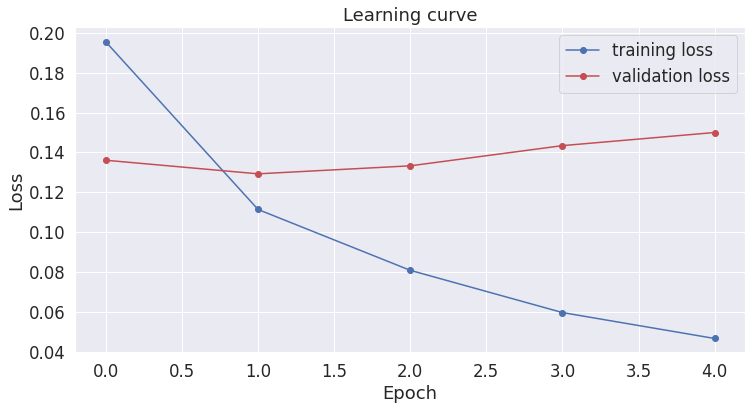

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


# Apply the model to a new sentence  
single text prediction

In [95]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""


In [96]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()


In [97]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [98]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)


In [99]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


O	[CLS]
B-per	Mr
B-per	.
I-per	Trump
O	’
O	s
O	tweets
O	began
O	just
O	moments
O	after
O	a
B-org	Fox
I-org	News
O	report
O	by
B-per	Mike
I-per	Tobin
O	,
O	a
O	reporter
O	for
O	the
O	network
O	,
O	about
O	protests
O	in
B-geo	Minnesota
O	and
O	elsewhere
O	.
O	[SEP]


#### **Saving the model for future use**

Finally, let's save the vocabulary (.txt) file, model weights (.bin) and the model's configuration (.json) to a directory, so that both the tokenizer and model can be re-loaded using the `from_pretrained()` class method.


In [100]:
import os

directory = "./model"

if not os.path.exists(directory):
    os.makedirs(directory)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(directory)
# save the model weights and its configuration file
model.save_pretrained(directory)


## .

---



**Refrences:**  
Notebook: https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/#fit-bert-for-named-entity-recognition  
Dataset: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner_dataset.csv

*Russell C.*